In [1]:
import pandas as pd
import numpy as np

# LOAD DATA
df_inflation = pd.read_csv('gdp_per_capita.csv', skiprows=4)
df_gdp = pd.read_csv('official_exchange.csv', skiprows=4)
df_exchange = pd.read_csv('inflation_annual.csv', skiprows=4)

# DATA CLEANING FUNCTION
def clean_worldbank_data(df, metric_name):
    """Clean World Bank CSV format"""
    # Select relevant years
    years = [str(year) for year in range(2005, 2024)]
    cols = ['Country Name', 'Country Code', 'Indicator Name'] + years

    df = df[cols]

    # Convert wide to long format
    df_long = df.melt(
        id_vars=['Country Name', 'Country Code', 'Indicator Name'],
        value_vars=years,
        var_name='Year',
        value_name=metric_name
    )

    # Convert Year to integer
    df_long['Year'] = df_long['Year'].astype(int)

    return df_long

# PROCESS ALL DATASETS
print("Processing inflation data...")
df_inf_clean = clean_worldbank_data(df_inflation, 'Inflation')

print("Processing GDP data...")
df_gdp_clean = clean_worldbank_data(df_gdp, 'GDP_per_capita')

print("Processing exchange rate data...")
df_ex_clean = clean_worldbank_data(df_exchange, 'Exchange_Rate')

Processing inflation data...
Processing GDP data...
Processing exchange rate data...


In [2]:
# MERGE DATASETS
df_merged = df_inf_clean.merge(
    df_gdp_clean, on=['Country Name', 'Country Code', 'Year']
).merge(
    df_ex_clean, on=['Country Name', 'Country Code', 'Year']
)

# CALCULATE KEY METRICS
# Inflation Shock
df_merged['Inflation_Shock'] = df_merged.groupby('Country Name')['Inflation'].transform(
    lambda x: x[(df_merged['Year'] >= 2021) & (df_merged['Year'] <= 2023)].mean() -
              x[(df_merged['Year'] >= 2015) & (df_merged['Year'] <= 2019)].mean()
)

# GDP Growth
df_merged['GDP_Growth_Pct'] = df_merged.groupby('Country Name')['GDP_per_capita'].pct_change(periods=4) * 100

# SAVE PROCESSED DATA
df_merged.to_csv('finall_countries_complete.csv', index=False)
print("✅ Analysis complete. Processed data saved.")

✅ Analysis complete. Processed data saved.


/tmp/ipython-input-3351570340.py:16: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_merged['GDP_Growth_Pct'] = df_merged.groupby('Country Name')['GDP_per_capita'].pct_change(periods=4) * 100


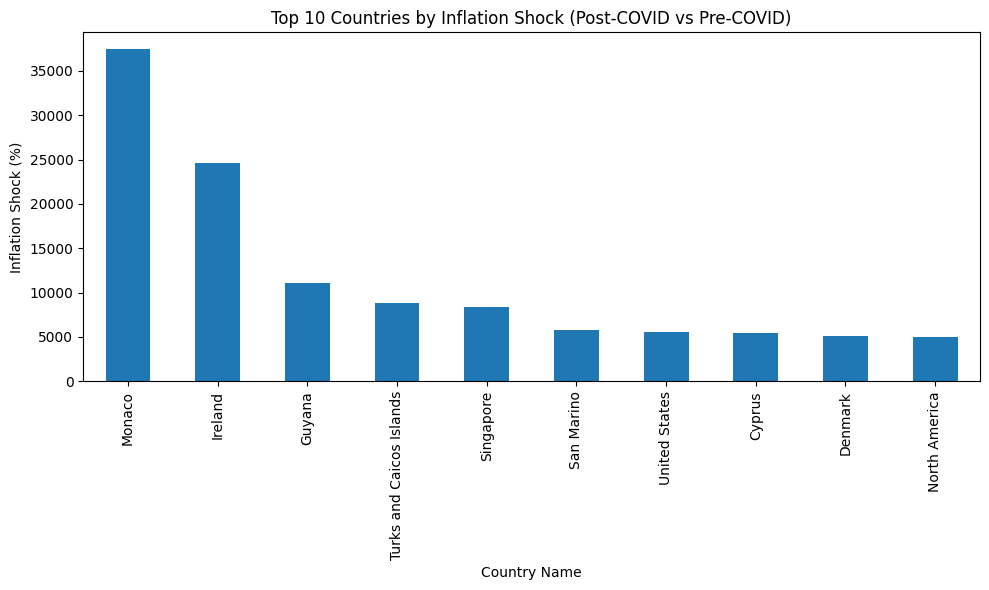

In [4]:
# CREATE SUMMARY VISUALIZATIONS
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 countries by inflation shock
top_countries = df_merged.groupby('Country Name')['Inflation_Shock'].mean().nlargest(10)

plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar')
plt.title('Top 10 Countries by Inflation Shock (Post-COVID vs Pre-COVID)')
plt.ylabel('Inflation Shock (%)')
plt.tight_layout()
plt.savefig('inflation_shock.png')
plt.show()